# Practical aspects of Image Classification

## Initialization

In [34]:
# Load libraries

# OS
import os

# Data manipulation, visualization and model building
from torch_snippets import *
from torchvision import transforms as T
from sklearn.model_selection import train_test_split

!nvidia-smi # check if GPU is available
%matplotlib inline

In [28]:
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", device)

Running on: cpu

In [21]:
# Unzip the dataset
root_dir = 'data/Malaria'
!cd {root_dir} && unzip -q -o cell_images.zip

## Class Activation Maps (CAMs)

In [23]:
# Set up class indexes
indexes = {'Parasitized': 0, 'Uninfected': 1}

In [26]:
# Create tranformations pipeline for input images
train_transforms = T.Compose([
    T.ToPILImage(),
    T.Resize(128),
    T.CenterCrop(128),
    T.ColorJitter(brightness=(0.95,1.05), contrast=(0.95,1.05), saturation=(0.95,1.05), hue=0.05),
    T.RandomAffine(5, translate=(0.01,0.1)),
    T.ToTensor(), # Get values between 0 and 1
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]), 
])

# Create tranformations pipeline for validation images
val_transforms = T.Compose([
    T.ToPILImage(),
    T.Resize(128),
    T.CenterCrop(128),
    T.ToTensor(), # Get values between 0 and 1
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]), 
])

In [30]:
# Create Dataset class to fetch images and labels
class MalariaDataset(Dataset):
    def __init__(self, files, transform=None):
        self.files = files
        self.transform = transform
        logger.info(len(self))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = self.files[idx]
        _class = fname(parent(file_path))
        image = read(file_path, 1)
        return image, _class

    def choose(self):
        return self[randint(len(self))]

    def collate_fn(self, batch):
        _images, classes = list(zip(*batch))
        if self.transform:
            images = [self.transform(image)[None] for image in _images]
        classes = [torch.tensor([indexes[_class]]) for _class in classes]
        images, classes = [torch.cat(el).to(device) for el in [images, classes]]
        return images, classes, _images

In [36]:
# Get the list of files
files = Glob(f'{root_dir}/cell_images/*/*.png')
print(f'Found {len(files)} files')

# Shuffle the files
np.random.shuffle(files)

# Get the train and validation files
train_files, val_files = train_test_split(files, test_size=0.2, random_state=4)

# Create the train and validation datasets
train_ds = MalariaDataset(train_files, transform=train_transforms)
val_ds = MalariaDataset(val_files, transform=val_transforms)

Found 27558 files

[02/19/24 16:51:55] INFO     22046                                                                                                                  ]8;id=324639;file:///var/folders/jf/sq6w1w1x7v9bvtbslbdtrlb00000gn/T/ipykernel_7751/2832931757.py:6\2832931757.py]8;;\:]8;id=407571;file:///var/folders/jf/sq6w1w1x7v9bvtbslbdtrlb00000gn/T/ipykernel_7751/2832931757.py:6#__init__:6\__init__:6]8;;\

                    INFO     5512                                                                                                                   ]8;id=805042;file:///var/folders/jf/sq6w1w1x7v9bvtbslbdtrlb00000gn/T/ipykernel_7751/2832931757.py:6\2832931757.py]8;;\:]8;id=230766;file:///var/folders/jf/sq6w1w1x7v9bvtbslbdtrlb00000gn/T/ipykernel_7751/2832931757.py:6#__init__:6\__init__:6]8;;\

In [37]:
# Create a function to retrieve the dataloaders
def load_data(batch_size):
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=train_ds.collate_fn)
    val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False, collate_fn=val_ds.collate_fn)

    return train_dl, val_dl

In [39]:
# Create a function to define a Convolutional Block
def convBlock(n_inputs, n_outputs):
    return nn.Sequential(
        nn.Dropout(0.2),
        nn.Conv2d(n_inputs, n_outputs, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(n_outputs),
        nn.MaxPool2d(2),
    )

# Create a class to define the Malaria classifier model
class MalariaClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            convBlock(3, 64),
            convBlock(64, 64),
            convBlock(64, 128),
            convBlock(128, 256),
            convBlock(256, 512),
            convBlock(512, 64),
            nn.Flatten(),
            nn.Linear(256, 256),
            nn.Dropout(0.2),
            nn.ReLU(inplace=True),
            nn.Linear(256, len(indexes))
        )
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)
    
    def compute_metrics(self, preds, targets):
        loss = self.loss_fn(preds, targets)
        acc = (torch.argmax(preds, 1) == targets).float().mean()
        return loss, acc

In [40]:
# Create a function to train the model on a batch of data
def train_batch(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    images, labels, _ = data
    _preds = model(images)
    loss, acc = criterion(_preds, labels)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

# Create a function to validate the model on a batch of data
@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    images, labels, _ = data
    _preds = model(images)
    loss, acc = criterion(_preds, labels)
    return loss.item(), acc.item()

In [41]:
# Train the model
model = MalariaClassifier().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
critertion = model.compute_metrics
train_dl, val_dl = load_data(batch_size=32)
n_epochs = 2
log = Report(n_epochs)

for epoch in range(n_epochs):
    n = len(train_dl)
    for i, data in enumerate(train_dl):
        loss, acc = train_batch(model, data, optimizer, critertion)
        log.record(epoch+(i+1)/n, train_loss=loss, train_acc=acc, end='\r')
    n = len(val_dl)
    for i, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, critertion)
        log.record(epoch+(i+1)/n, val_loss=loss, val_acc=acc, end='\r')
    log.report_avgs(epoch+1)

EPOCH: 1.000  train_loss: 0.230  train_acc: 0.914  val_acc: 0.948  val_loss: 0.180  (1200.19s - 1200.19s remaining)
EPOCH: 2.000  train_loss: 0.170  train_acc: 0.947  val_acc: 0.947  val_loss: 0.260  (2368.43s - 0.00s remaining)


In [59]:
# Construct the model from the first layer up to the first convolutional layer on the 5th block to extract features
img2fmap = nn.Sequential(*(list(model.model[:5].children()) + list(model.model[5][:2].children())))

In [60]:
# Create a function that will extract the features from the model given an input image 
def im2gradCAM(image):
    # Get a prediction
    model.eval()
    logits = model(image)
    activations = img2fmap(image)
    print(f'Activations shape: {activations.shape}')
    pred = logits.max(-1)[-1]

    # Compute gradients with respect to the most confident logit
    model.zero_grad()
    logits[0,pred].backward(retain_graph=True)

    # Get the gradients at the required featuremap location and take the avg gradient for every featuremap
    pooled_grads = model.model[-6][1].weight.grad.data.mean((1,2,3))

    # Multiply each activation map with its corresponding gradient average
    for i in range(activations.shape[1]):
        activations[:,i,:,:] *= pooled_grads[i]

    # Take the mean of all weighted activation maps (that has been weighted by avg. grad at each fmap)
    heatmap = torch.mean(activations, dim=1)[0].cpu().detach()
    return heatmap, 'Uninfected' if pred.item() else 'Parasitized'

In [63]:
# Create a function to upsample the heatmap to the original image size
def upsampleHeatmap(heatmap, image):
    # Normalize the heatmap
    heatmap = ((heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())) * 255
    heatmap = np.uint8(heatmap)
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    # Convert heatmap to float32 for consistency with image processing
    heatmap = heatmap.astype(np.float32) / 255

    # Normalize and prepare the image
    image = (image - image.min()) / (image.max() - image.min())
    image = (image * 255).astype(np.float32) / 255  # Ensure image is float32

    # Blend the heatmap and image
    return cv2.addWeighted(heatmap, 0.5, image, 0.5, 0)

Activations shape: torch.Size([1, 64, 4, 4])

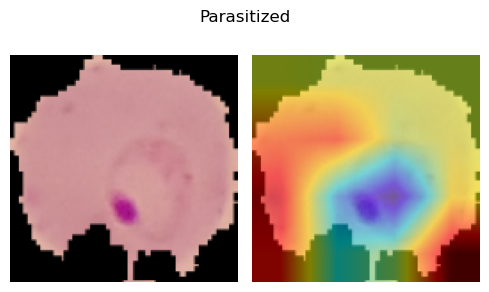

Activations shape: torch.Size([1, 64, 4, 4])

Activations shape: torch.Size([1, 64, 4, 4])

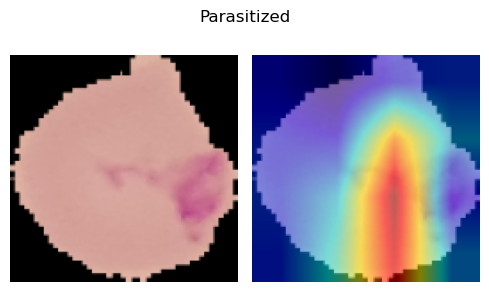

Activations shape: torch.Size([1, 64, 4, 4])

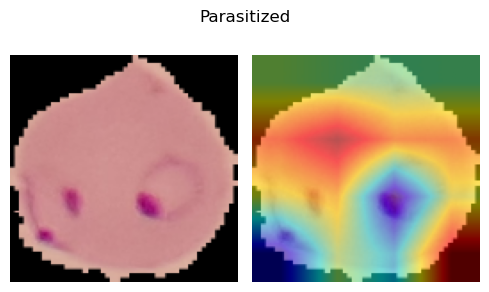

Activations shape: torch.Size([1, 64, 4, 4])

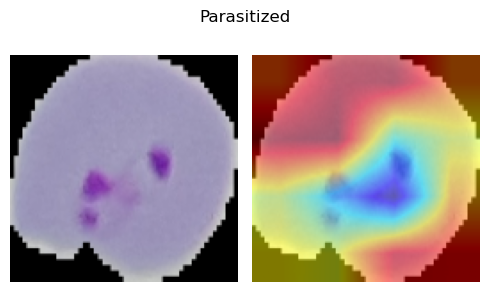

Activations shape: torch.Size([1, 64, 4, 4])

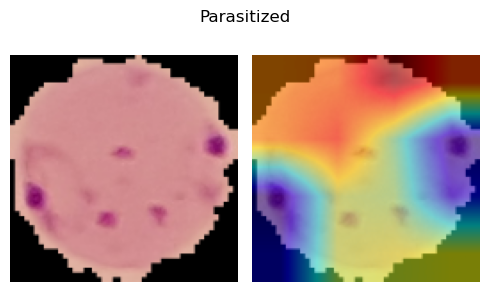

In [74]:
# Plot the heatmap for the first 5 images in the validation dataloader
_val_dl = DataLoader(val_ds, batch_size=32, shuffle=True, collate_fn=val_ds.collate_fn)
x,y,z = next(iter(_val_dl))

counter = 0
for i in range(32):
    if counter == 5:
        break
    image = resize(z[i], 128)
    heatmap, pred = im2gradCAM(x[i:i+1])
    if(pred=='Uninfected'):
        continue
    else:
        counter += 1
    heatmap = upsampleHeatmap(heatmap, image)
    subplots([image, heatmap], nc=2, figsize=(5,3), suptitle=pred)